In [1]:
'''
This script uses the EV Charging behaviours dataset (xlsx format)
The script aims to predict charging cost of charging transactions
It applies classic regression and lasso regression.
'''

In [2]:
import numpy as np
import datetime as dt
import sklearn
import pandas as pd
from sklearn import preprocessing 

In [3]:
# read data


df = pd.read_excel (r'Data/EV Charging behaviours.xlsx',sheet_name='enlarged data')

In [4]:
# encoding of non numerical data


from sklearn.preprocessing import OneHotEncoder
X=df
le = preprocessing.LabelEncoder()
X['Driver has home charger'] = le.fit_transform(X['Driver has home charger'].astype(str))
enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
enc_df = pd.DataFrame(enc.fit_transform(X[['Main Office','car type','Weekday','Laadpaaltype']]).toarray())
X = X.join(enc_df)


In [5]:
#clean data


X=X.dropna()

In [6]:
# select target feature to predict


y_kost=X['€ / kWh']

In [7]:
# Decide what features to take into account in the model


duration = True
percent_charged= True
battery_size=True
percent_laadpaal=True
laadpaaltype=True
home_charger=True
main_office=True
car_type=True
year=True
weekday=True

In [8]:
# select features



selection=[]
labels=[]

if duration:
    selection.append('Duration in minutes')
if percent_charged:
    selection.append('% of battery charged')
if battery_size:
    selection.append('Battery size')
if percent_laadpaal:
    selection.append('% laadpaal vermogen')
if home_charger:
    selection.append('Driver has home charger')
if year:
    selection.append('Year')


    
    
labels=selection.copy()
used_params=selection.copy()
onehot_counter=0


offices=X['Main Office'].unique()
nb_officess=len(offices.tolist())
if main_office:
    classes=[onehot_counter+i for i in range(nb_officess)]
    selection=selection+classes
    labels=labels+offices.tolist()
    used_params.append('Main office')
onehot_counter=onehot_counter+nb_officess

car_types=X['car type'].unique()
nb_car_types=len(car_types.tolist())
if car_type:
    classes=[onehot_counter+i for i in range(nb_car_types)]
    selection=selection+classes
    labels=labels+car_types.tolist()
    used_params.append('car type')
onehot_counter=onehot_counter+nb_car_types

weekdays=X['Weekday'].unique()
nb_weekdays=7
if car_type:
    classes=[onehot_counter+i for i in range(nb_weekdays)]
    selection=selection+classes
    labels=labels+weekdays.tolist()
    used_params.append('Weekday')
onehot_counter=onehot_counter+nb_weekdays

laadpaaltypes=X['Laadpaaltype'].unique()
nb_laadpaaltypes=3
if laadpaaltype:
    classes=[onehot_counter+i for i in range(nb_laadpaaltypes)]
    selection=selection+classes
    labels=labels+laadpaaltypes.tolist()
    used_params.append('Laadpaaltype')
onehot_counter=onehot_counter+nb_car_types

X_selection= X[selection]


In [9]:
# scale data
# regression requires data to be scaled (<=> trees)

scaler = preprocessing.StandardScaler().fit(X_selection)
X_scaled = scaler.transform(X_selection)

In [10]:
# random train test split

from sklearn import tree
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_kost, test_size=0.33, random_state=42)

In [11]:
# lasso regression

from sklearn import linear_model
from sklearn import metrics

clf_lasso = linear_model.Lasso()
clf_lasso=clf_lasso.fit(X_train, y_train)

print('train score lasso:' + str(clf_lasso.score(X_train, y_train)))
print('test score lasso:' + str(clf_lasso.score(X_test, y_test)))

y_lasso_test=clf_lasso.predict(X_test)


print('mean_absolute_error lasso:' + str(metrics.mean_absolute_error (y_lasso_test,y_test)))




train score lasso:0.0
test score lasso:-0.00034410977101151374
mean_absolute_error lasso:0.05470663688643317


(13351, 77)
Computing regularization path using the LARS ...
.

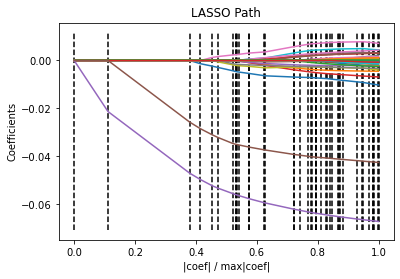

0.2795799957630838


In [12]:
# visualize lasso path

import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from sklearn import datasets


X_lasso=X_scaled
y=y_kost.to_numpy()
#X, y = datasets.load_diabetes(return_X_y=True)
print(X.shape)

print("Computing regularization path using the LARS ...")
_, _, coefs = linear_model.lars_path(X_lasso, y, method='lasso', verbose=True)

xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.show()



coeffs = clf_lasso.coef_         # dense np.array
sparse_coeffs = clf_lasso.sparse_coef_  # sparse matrix

intercept_coeffs = clf_lasso.intercept_    # probably also relevant
print(clf_lasso.intercept_)

In [13]:
# get names of features back for non numerical data


features=selection.copy()
for i in range(len(features)):
    featr=features[i]
    if isinstance(featr, int):
        if featr<=9:
            features[i]=offices[featr]
        elif featr<=29:
            features[i]=car_types[featr-10]
        elif featr<=36:
            features[i]=weekdays[featr-30]
        else:
            features[i]=laadpaaltypes[featr-37]


In [14]:
# model evaluation

from sklearn import linear_model
from sklearn.metrics import mean_absolute_error 

clf_ridge = linear_model.Ridge()
clf_ridge=clf_ridge.fit(X_train, y_train)

print('train score ridge:' + str(clf_ridge.score(X_train, y_train)))
print('test score ridge:' + str(clf_ridge.score(X_test, y_test)))
y_ridge_test=clf_ridge.predict(X_test)
y_ridge_train=clf_ridge.predict(X_train)

print('mean_absolute_error ridge test:' + str(mean_absolute_error (y_ridge_test,y_test)))
print('mean_absolute_error ridge train:' + str(mean_absolute_error (y_ridge_train,y_train)))


from scipy import stats
stats.median_abs_deviation(y_test)

train score ridge:0.619250302228372
test score ridge:0.5776122668313246
mean_absolute_error ridge test:0.029947902590884302
mean_absolute_error ridge train:0.029669022390554675


0.0331280488579791

In [15]:
# prints the values and magnitudes of the lasso model coefficients for each feature, sorted


comps=clf_ridge.coef_         # dense np.array
abs_comp =  np.array([abs(el) for el in comps])

#sort
inds=abs_comp.argsort()
vals=[comps[i] for i in inds]
print(vals)
features=[selection[i] for i in inds]
for i in range(len(features)):
    featr=features[i]
    if isinstance(featr, int):
        if featr<=9:
            features[i]=offices[featr]
        elif featr<=29:
            features[i]=car_types[featr-10]
        elif featr<=36:
            features[i]=weekdays[featr-30]
        else:
            features[i]=laadpaaltypes[featr-37]
            
print(features)

        

[0.0, 0.00015849937590993563, -0.00016626062588150062, -0.00018033477989933116, 0.00018690574286290014, -0.0001951416701219875, -0.0002619236435029678, -0.00030472684013582734, 0.00030572384556959225, -0.00033011946332260557, 0.00035034205383241857, -0.00036289941895473925, 0.0005597906710747694, -0.0005800732155186131, 0.0007323496471112302, -0.0008495617122085233, 0.0008603231296134851, -0.0008896853582867653, -0.0009219568917243744, -0.0010342621422121637, 0.0011837633067086, -0.0011983254061631416, 0.0012935171951973918, -0.001427098128433982, 0.0014470623459754326, 0.001450697619365677, 0.0015200910675867286, -0.0015220286058275092, 0.0016072723919357765, -0.0022053129570783476, 0.002571032145582191, -0.0026274899575611174, -0.0027968978926965387, 0.0028593214952680325, -0.0028743240224997947, -0.0029967357443118244, 0.0037985818891768794, 0.0038195695875729843, 0.004356835355244299, -0.004463394546433733, -0.004545574529059166, -0.006970422503201954, 0.006988710474450802, -0.0105

In [16]:
# linear regression as comparison

from sklearn import linear_model
from sklearn.metrics import mean_absolute_error 

clf_lin = linear_model.LinearRegression()
clf_lin=clf_lin.fit(X_train, y_train)

print('train score lin:' + str(clf_ridge.score(X_train, y_train)))
print('test score lin:' + str(clf_ridge.score(X_test, y_test)))
y_lin_test=clf_lin.predict(X_test)
y_lin_train=clf_lin.predict(X_train)

print('mean_absolute_error lin test:' + str(mean_absolute_error (y_lin_test,y_test)))
print('mean_absolute_error lin train:' + str(mean_absolute_error (y_lin_train,y_train)))


train score lin:0.619250302228372
test score lin:0.5776122668313246
mean_absolute_error lin test:0.029954729845059994
mean_absolute_error lin train:0.029675802479634264
